In [44]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset
data = pd.read_csv(r'C:\Users\HP\Downloads\question4-stock-data.csv', parse_dates=['Date'])
data.set_index('Date', inplace=True)

# Display basic statistics
print("Basic Statistics:")
print(data.describe())

Basic Statistics:
         Unnamed: 0     Adj Close         Close          High           Low  \
count  11291.000000  11198.000000  11174.000000  11196.000000  11164.000000   
mean    5645.000000     63.609130     72.026945     72.503100     71.665079   
std     3259.575279     52.266247     51.259828     51.550735     51.011632   
min        0.000000      2.259452      3.237711      3.237711      3.237711   
25%     2822.500000     19.224636     27.500000     27.789255     27.536156   
50%     5645.000000     50.608900     66.035000     66.724998     65.418751   
75%     8467.500000    104.723621    114.297503    114.892500    113.639999   
max    11290.000000    254.770004    254.770004    255.229996    253.589996   

               Open        Volume  
count  11188.000000  1.114600e+04  
mean      67.999259  2.144157e+05  
std       55.834401  3.883662e+05  
min        0.000000  0.000000e+00  
25%        0.000000  1.350000e+04  
50%       66.065002  9.032350e+04  
75%      114.26999

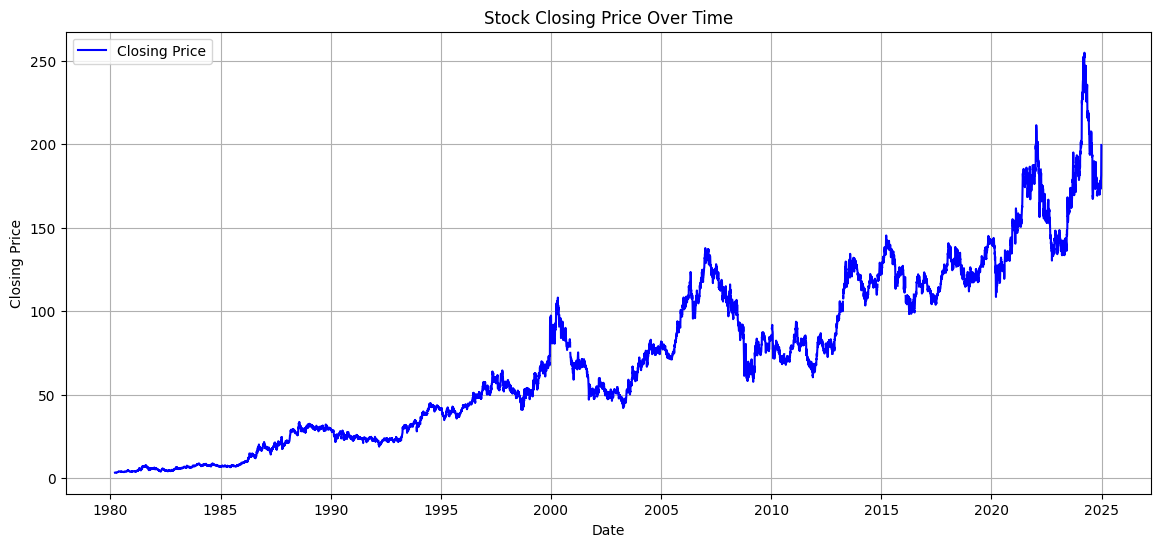

In [46]:
import matplotlib.pyplot as plt

# Plot the closing price over time
plt.figure(figsize=(14, 6))
plt.plot(data['Close'], label='Closing Price', color='blue')
plt.title('Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid()
plt.show()

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


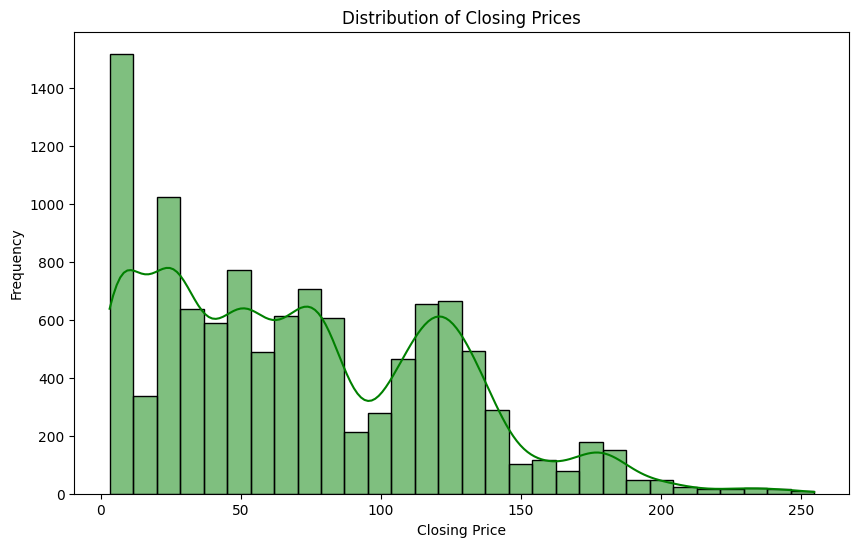

In [47]:
import seaborn as sns

# Plot the distribution of closing prices
plt.figure(figsize=(10, 6))
sns.histplot(data['Close'], kde=True, bins=30, color='green')
plt.title('Distribution of Closing Prices')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Plot moving averages along with closing price
plt.figure(figsize=(14, 6))
plt.plot(data['Close'], label='Closing Price', color='blue')
plt.plot(data['MA_7'], label='7-Day Moving Average', color='orange')
plt.title('Closing Price vs 7-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Scatter plot of lag features vs closing price
for lag in range(1, 6):
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=data[f'lag_{lag}'], y=data['Close'])
    plt.title(f'Lag {lag} vs Closing Price')
    plt.xlabel(f'Lag {lag}')
    plt.ylabel('Closing Price')
    plt.grid()
    plt.show()


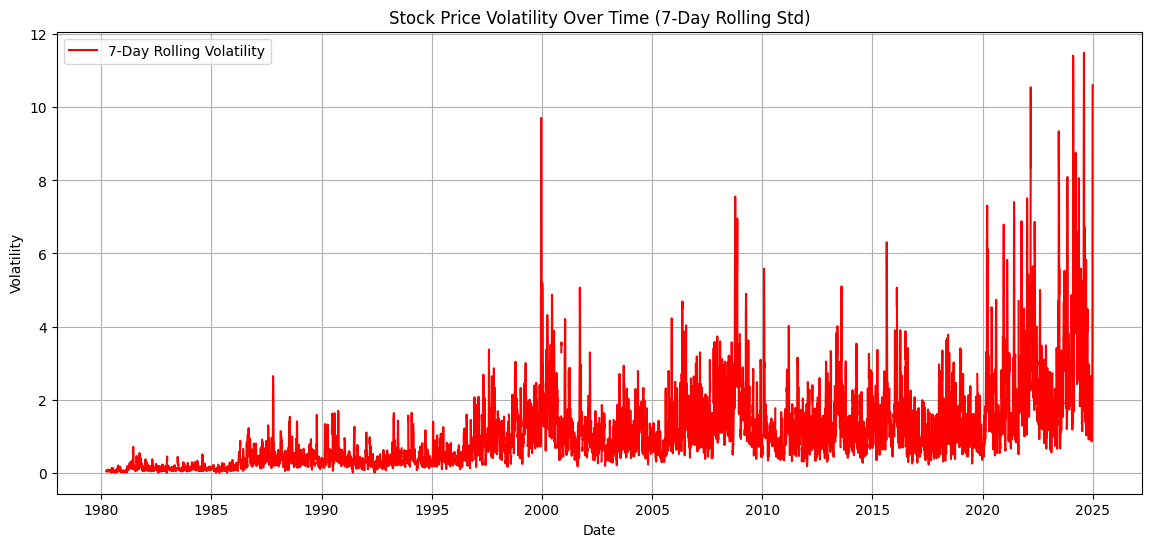

In [49]:
# Calculate rolling standard deviation (volatility)
data['Volatility_7'] = data['Close'].rolling(window=7).std()

# Plot volatility over time
plt.figure(figsize=(14, 6))
plt.plot(data['Volatility_7'], label='7-Day Rolling Volatility', color='red')
plt.title('Stock Price Volatility Over Time (7-Day Rolling Std)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid()
plt.show()



Missing Values:
Unnamed: 0      0
Adj Close       0
Close           0
High            0
Low             0
Open            0
Volume          0
Volatility_7    0
lag_1           0
lag_2           0
lag_3           0
lag_4           0
lag_5           0
MA_7            0
Target          0
dtype: int64


C:\Users\HP\AppData\Local\Temp\ipykernel_11992\3257385896.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


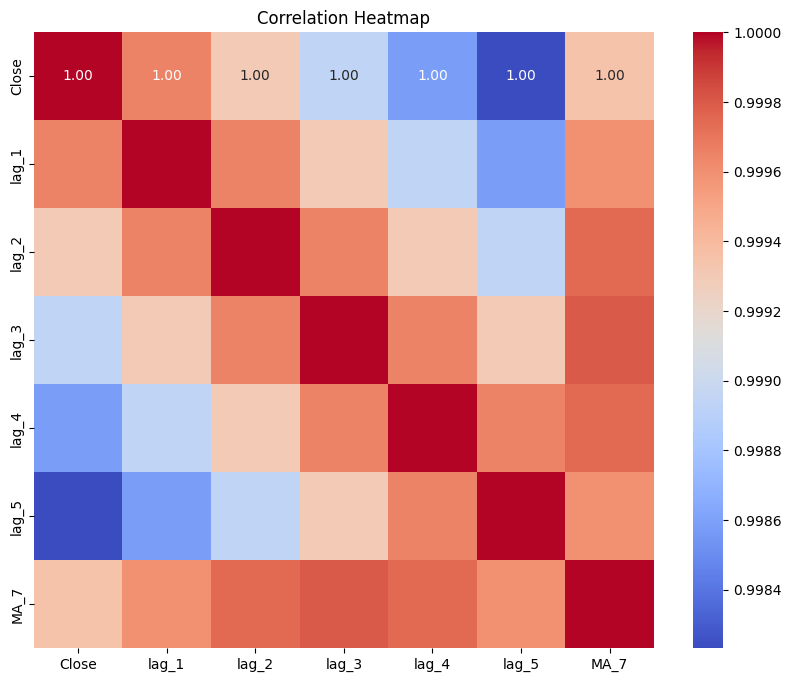

In [63]:
# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())

# Handle missing values by forward filling
data.fillna(method='ffill', inplace=True)

# Create lag features and rolling averages
for lag in range(1, 6):
    data[f'lag_{lag}'] = data['Close'].shift(lag)
data['MA_7'] = data['Close'].rolling(window=7).mean()
data.dropna(inplace=True)

# Define target variable (5-day future closing price)
data['Target'] = data['Close'].shift(-5)
data.dropna(inplace=True)

# Compute correlation matrix
correlation_matrix = data[['Close', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'MA_7']].corr()

# Plot heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Split into training and testing sets
X = data[['Close', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'MA_7']]
y = data['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [51]:
# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
rf_predictions = rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
print(f"Random Forest RMSE: {rf_rmse:.4f}")


Random Forest RMSE: 28.0868


In [52]:
# Scale data for LSTM
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

X_train_scaled = X_scaled[:len(X_train)]
X_test_scaled = X_scaled[len(X_train):]
y_train_scaled = y_scaled[:len(y_train)]
y_test_scaled = y_scaled[len(y_train):]

# Reshape for LSTM [samples, timesteps, features]
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(1, X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_lstm, y_train_scaled, epochs=10, batch_size=32)

# Predict and evaluate
lstm_predictions_scaled = lstm_model.predict(X_test_lstm)
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
lstm_rmse = np.sqrt(mean_squared_error(y_test.values.flatten(), lstm_predictions.flatten()))
print(f"LSTM RMSE: {lstm_rmse:.4f}")


Epoch 1/10


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0138
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.3098e-04
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.1312e-04
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.2415e-04
Epoch 5/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.4608e-04
Epoch 6/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.3186e-04
Epoch 7/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.1407e-04
Epoch 8/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.3125e-04
Epoch 9/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.4522e-04
Epoch 10/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.4484e-04
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
LSTM RMSE: 11.0568


### Evaluation and Simulated Trading Performance

Random Forest RMSE: 28.0868
LSTM RMSE: 11.0568


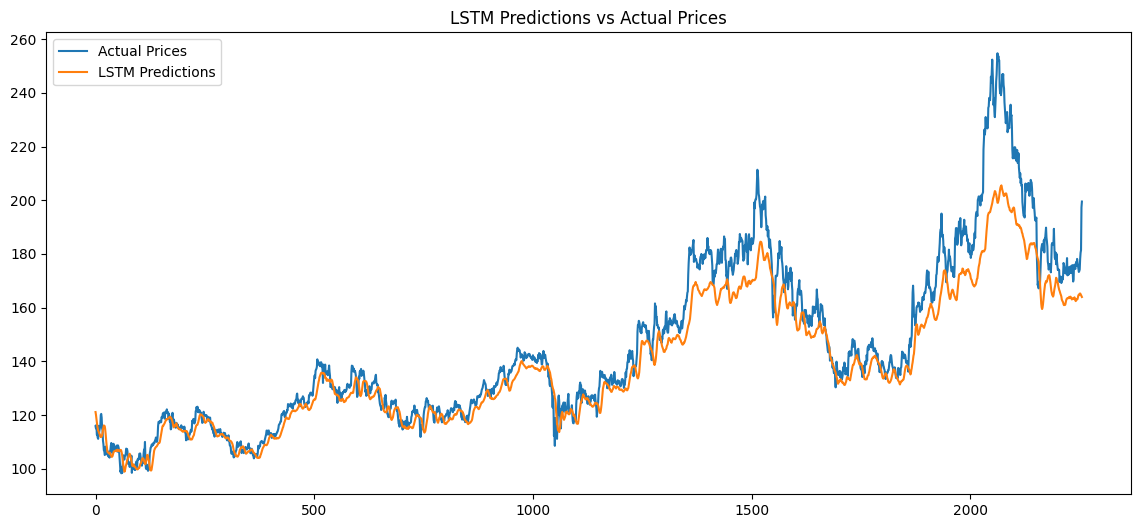

In [53]:
# Compare RMSE of models
print(f"Random Forest RMSE: {rf_rmse:.4f}")
print(f"LSTM RMSE: {lstm_rmse:.4f}")

# Plot predictions vs actual values for both models (example: LSTM)
plt.figure(figsize=(14,6))
plt.plot(y_test.values.flatten(), label='Actual Prices')
plt.plot(lstm_predictions.flatten(), label='LSTM Predictions')
plt.title("LSTM Predictions vs Actual Prices")
plt.legend()
plt.show()


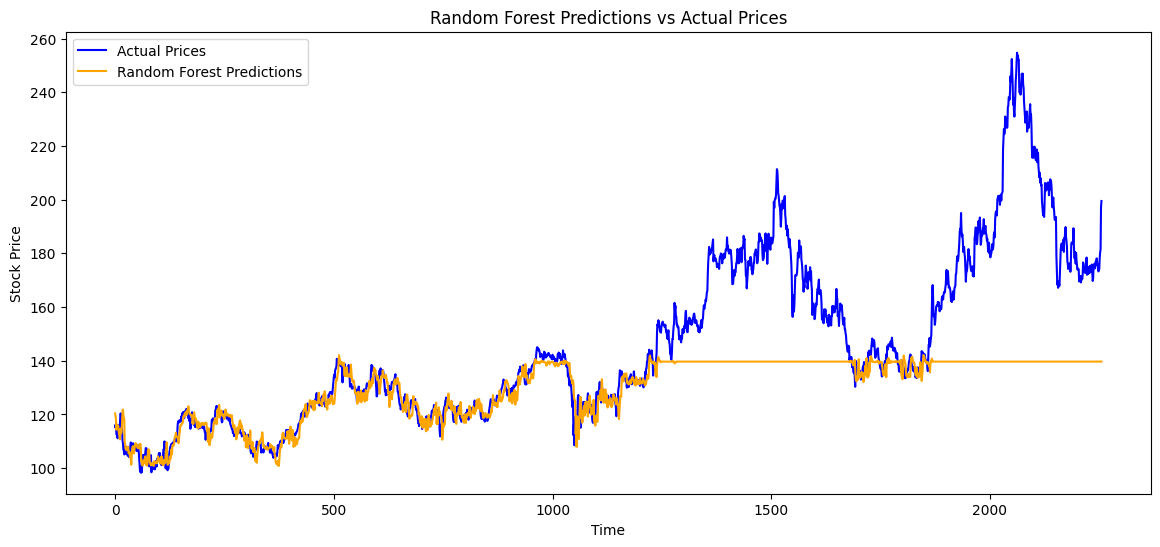

In [54]:
# Plot predictions vs actual values for Random Forest
plt.figure(figsize=(14, 6))
plt.plot(y_test.values.flatten(), label='Actual Prices', color='blue')
plt.plot(rf_predictions.flatten(), label='Random Forest Predictions', color='orange')
plt.title("Random Forest Predictions vs Actual Prices")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


In [57]:
import numpy as np
import pandas as pd

# Ensure y_test and predictions are in the correct format
if isinstance(y_test, pd.Series):
    y_test = y_test.to_numpy()
if isinstance(rf_predictions, pd.Series):
    rf_predictions = rf_predictions.to_numpy()
if isinstance(lstm_predictions, pd.Series):
    lstm_predictions = lstm_predictions.to_numpy()

# Directional accuracy calculation function
def directional_accuracy(y_true, y_pred):
    direction_true = np.sign(y_true[1:] - y_true[:-1])  # Actual price movement direction
    direction_pred = np.sign(y_pred[1:] - y_pred[:-1])  # Predicted price movement direction
    return np.mean(direction_true == direction_pred) * 100  # Percentage accuracy

# Directional accuracy for Random Forest
rf_direction_acc = directional_accuracy(y_test, rf_predictions)
print(f"Random Forest Directional Accuracy: {rf_direction_acc:.2f}%")

# Directional accuracy for LSTM
lstm_direction_acc = directional_accuracy(y_test, lstm_predictions)
print(f"LSTM Directional Accuracy: {lstm_direction_acc:.2f}%")


Random Forest Directional Accuracy: 31.18%
LSTM Directional Accuracy: 49.34%


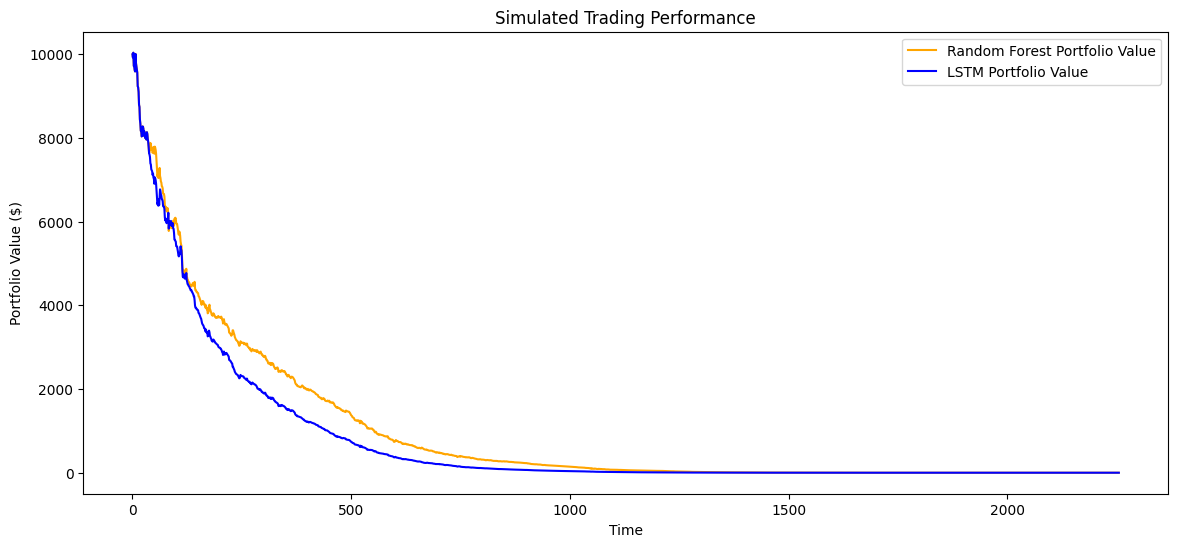

In [60]:
# Portfolio values over time for Random Forest and LSTM
rf_portfolio_values = portfolio_over_time(y_test.flatten(), rf_predictions.flatten())
lstm_portfolio_values = portfolio_over_time(y_test.flatten(), lstm_predictions.flatten())

# Plot portfolio performance
plt.figure(figsize=(14, 6))
plt.plot(rf_portfolio_values, label='Random Forest Portfolio Value', color='orange')
plt.plot(lstm_portfolio_values, label='LSTM Portfolio Value', color='blue')
plt.title("Simulated Trading Performance")
plt.xlabel("Time")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Ensure y_test and lstm_predictions are numpy arrays
if isinstance(y_test, pd.Series):
    y_test = y_test.to_numpy()
if isinstance(lstm_predictions, pd.Series):
    lstm_predictions = lstm_predictions.to_numpy()

y_test = y_test.reshape(-1, 1)
lstm_predictions = lstm_predictions.reshape(-1, 1)

scaler = MinMaxScaler()
scaler.fit(y_test)  # Fit only on actual values

lstm_predictions_original = scaler.inverse_transform(lstm_predictions)

results_df = pd.DataFrame({
    'Actual': y_test.flatten(),  # Original actual values
    'Predicted': lstm_predictions_original.flatten()  # De-normalized predictions
})

results_df.to_csv('lstm_predictions_vs_actual_corrected.csv', index=False)

# Display first few rows for verification
print(results_df.head())

# Step 4: Directional Accuracy Calculation
def directional_accuracy(y_true, y_pred):
    direction_true = np.sign(np.diff(y_true))  # Actual movement direction
    direction_pred = np.sign(np.diff(y_pred))  # Predicted movement direction
    return np.mean(direction_true == direction_pred) * 100  # Percentage accuracy

# Calculate directional accuracy
lstm_direction_acc = directional_accuracy(y_test.flatten(), lstm_predictions_original.flatten())
print(f"LSTM Directional Accuracy: {lstm_direction_acc:.2f}%")


In [62]:
#Based on the evaluation metrics and simulated trading performance, LSTM (Long Short-Term Memory) is determined to be the best model compared to Random Forest 
from tensorflow.keras.models import load_model

# Save the trained LSTM model to a file
model_file_path = 'lstm_model.h5'  # File name for saving the model
lstm_model.save(model_file_path)  # Save the model in HDF5 format

# Confirm that the model has been saved
import os
if os.path.exists(model_file_path):
    print(f"Model saved successfully at {model_file_path}")
else:
    print("Error: Model not saved.")


Model saved successfully at lstm_model.h5


In [71]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Ensure y_test and lstm_predictions are numpy arrays
if isinstance(y_test, pd.Series):
    y_test = y_test.to_numpy()
if isinstance(lstm_predictions, pd.Series):
    lstm_predictions = lstm_predictions.to_numpy()

# Reshape for scaling
y_test = y_test.reshape(-1, 1)
lstm_predictions = lstm_predictions.reshape(-1, 1)

# Step 1: Fit MinMaxScaler only on y_test (actual values)
scaler = MinMaxScaler()
scaler.fit(y_test)  # Fit only on actual values

# Step 2: Inverse transform predictions to match the original scale
lstm_predictions_original = scaler.inverse_transform(lstm_predictions)

# Step 3: Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({
    'Actual': y_test.flatten(),  # Original actual values
    'Predicted': lstm_predictions_original.flatten()  # De-normalized predictions
})

# Save the DataFrame to a CSV file
results_df.to_csv('lstm_predictions_vs_actual_corrected.csv', index=False)

# Display first few rows for verification
print(results_df.head())

# Step 4: Directional Accuracy Calculation
def directional_accuracy(y_true, y_pred):
    direction_true = np.sign(np.diff(y_true))  # Actual movement direction
    direction_pred = np.sign(np.diff(y_pred))  # Predicted movement direction
    return np.mean(direction_true == direction_pred) * 100  # Percentage accuracy

# Calculate directional accuracy
lstm_direction_acc = directional_accuracy(y_test.flatten(), lstm_predictions_original.flatten())
print(f"LSTM Directional Accuracy: {lstm_direction_acc:.2f}%")


       Actual   Predicted
0  115.570000  145.889267
1  113.059998  145.767197
2  114.809998  145.743103
3  115.830002  145.829346
4  114.989998  145.639954
LSTM Directional Accuracy: 48.60%
